[ 임소영 ] 의사결정트리, 부스팅

[ 피쳐-(임시) ] 단백질(g),나트륨(mg) ,당류(g), 포화지방(g)

[ 데이터셋 ] 
- 맥도날드 : https://www.kaggle.com/datasets/mcdonalds/nutrition-facts
- 롯데리아 : https://www.lotteeatz.com/upload/stg/etc/ria/items.html
- 미국 전 지점 : https://www.kaggle.com/datasets/ulrikthygepedersen/fastfood-nutrition
- 버거킹 : https://emilysinglelife.tistory.com/62
- 맘스터치(이미지) : https://www.momstouch.co.kr/m/brand/notice-view.php?idx=49
- 노브랜드 : https://realjace.tistory.com/entry/%EB%85%B8%EB%B8%8C%EB%9E%9C%EB%93%9C%EB%B2%84%EA%B1%B0-%EB%A9%94%EB%89%B4%EB%B3%84-%EC%B9%BC%EB%A1%9C%EB%A6%AC-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84-%EC%B4%9D%EC%A0%95%EB%A6%AC
- 프랭크 버거 : https://rooftoper.tistory.com/entry/%ED%94%84%EB%9E%AD%ED%81%AC-%EB%B2%84%EA%B1%B0-%EC%98%81%EC%96%91%EC%84%B1%EB%B6%84

## 자료 준비, 전처리 (결측치, 중복값, 이상치)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
file = './Hamburger.csv'
data = pd.read_csv(file)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   restaurant  1068 non-null   object 
 1   item        1068 non-null   object 
 2   calories    1068 non-null   float64
 3   sodium      1068 non-null   float64
 4   sugar       1068 non-null   float64
 5   total_fat   1068 non-null   float64
 6   protein     1068 non-null   float64
dtypes: float64(5), object(2)
memory usage: 58.5+ KB


In [3]:
data.isna().sum()

restaurant    0
item          0
calories      0
sodium        0
sugar         0
total_fat     0
protein       0
dtype: int64

In [4]:
data.duplicated().sum()

2

In [5]:
data

,restaurant,item,calories,sodium,sugar,total_fat,protein
0,Mcdonalds,Artisan Grilled Chicken Sandwich,380.00,1110.00,11.00,7.00,37.00
1,Mcdonalds,Single Bacon Smokehouse Burger,840.00,1580.00,18.00,45.00,46.00
2,Mcdonalds,Double Bacon Smokehouse Burger,1130.00,1920.00,18.00,67.00,70.00
3,Mcdonalds,Grilled Bacon Smokehouse Chicken Sandwich,750.00,1940.00,18.00,31.00,55.00
4,Mcdonalds,Crispy Bacon Smokehouse Chicken Sandwich,920.00,1980.00,18.00,45.00,46.00
...,...,...,...,...,...,...,...
1063,prank_burger,더블치즈버거(L),687.04,4.55,33.45,19.51,1149.60
1064,prank_burger,머쉬룸버거(L),665.30,13.58,26.75,18.10,1203.43
1065,prank_burger,JG버거(L),828.28,6.42,48.23,22.28,1574.77
1066,prank_burger,SG불고기버거(L),491.06,13.84,17.24,10.60,606.15


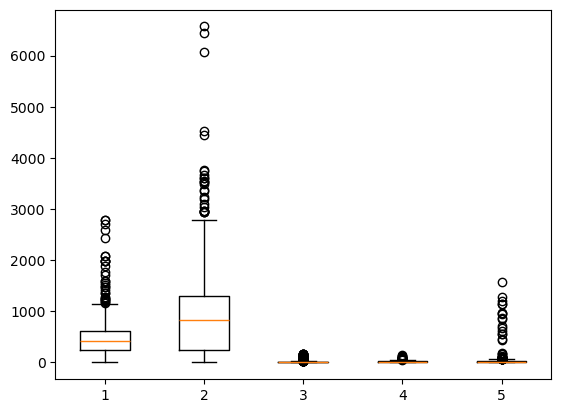

In [6]:
plt.boxplot(data[['calories','sodium','sugar','total_fat','protein']])
plt.show()

In [7]:
def print_flier(insert_data):
    q1 = insert_data.quantile(0.25)
    q3 = insert_data.quantile(0.75)
    iqr = q3 - q1
    #print(f"[ q1 ] \n{q1}\n\n[ q3 ] \n{q3}\n")
    #print(f"[ iqr의 범위 ]\n{iqr}\n")

    print('------------------ 이상값이 될 기준 계산 ------------------\n')

    lower = q1 - 1.5 * iqr
    #print(f"[ lower의 값 ]\n{lower}\n")
    upper = q3 + 1.5 * iqr
    #print(f"[ upper의 값 ]\n{upper}\n")

    mask = insert_data < lower
    print(f"[ lower의 개수 ]\n{mask.sum()}\n")
    mask2 = insert_data > upper
    print(f"[ upper의 개수 ]\n{mask2.sum()}\n")

    return lower, upper

lower, upper = print_flier(data[['calories','sodium','sugar','total_fat','protein']])

------------------ 이상값이 될 기준 계산 ------------------

[ lower의 개수 ]
calories     0
sodium       0
sugar        0
total_fat    0
protein      0
dtype: int64

[ upper의 개수 ]
calories      31
sodium        26
sugar        150
total_fat     33
protein       45
dtype: int64


In [8]:
data[['calories','sodium','sugar','total_fat','protein']].shape

(1068, 5)

In [9]:
def drop_flier(insert_data, col_name):
    global lower
    global upper
    print(f"이상치 제거 전 shape 확인: {insert_data.shape}")
    mask = insert_data[col_name] >= lower.loc[col_name]
    insert_data = insert_data[mask]
    #print(f" '{col_name}' 컬럼에서 lower 미만의 값 제거 후 shape: {insert_data.shape}")

    mask2 = insert_data[col_name] <= upper.loc[col_name]
    insert_data = insert_data[mask2]
    #print(f" '{col_name}' 컬럼에서 upper 초과의 값 제거 후 shape: {insert_data.shape}\n")
    
    print(f"이상치 제거 후 shape 확인: {insert_data.shape} \n")
    return insert_data

# data_for_drop = data[['calories','sodium','sugar','total_fat','protein']]
# data_for_drop = drop_flier(data_for_drop, 'calories')
# data_for_drop = drop_flier(data_for_drop, 'sodium')
# data_for_drop = drop_flier(data_for_drop, 'sugar')
# data_for_drop = drop_flier(data_for_drop, 'total_fat')
# data_for_drop = drop_flier(data_for_drop, 'protein')

# 이상치 제거한 데이터에 맞게 원본 데이터도 제거된 인덱스 번호를 같이 drop 시켜줌
# for i in list(data.index):
#     if i not in (list(data_for_drop.index)):
#         data.drop(i,inplace = True)
# print(data.shape)
# 인덱스 번호가 서로 일치하는지 확인
# print(len(list(data_for_drop.index)) == len(list(data.index)))
# 서로 일치하는 것을 확인 했으니 이 데이터를 이용해서 알고리즘 돌리겠다.

In [10]:
data.corr(numeric_only=True)

,calories,sodium,sugar,total_fat,protein
calories,1.000000,0.811985,0.305116,0.723007,0.172215
sodium,0.811985,1.000000,-0.096722,0.706815,0.005060
sugar,0.305116,-0.096722,1.000000,-0.055567,0.065918
total_fat,0.723007,0.706815,-0.055567,1.000000,0.093055
protein,0.172215,0.005060,0.065918,0.093055,1.000000


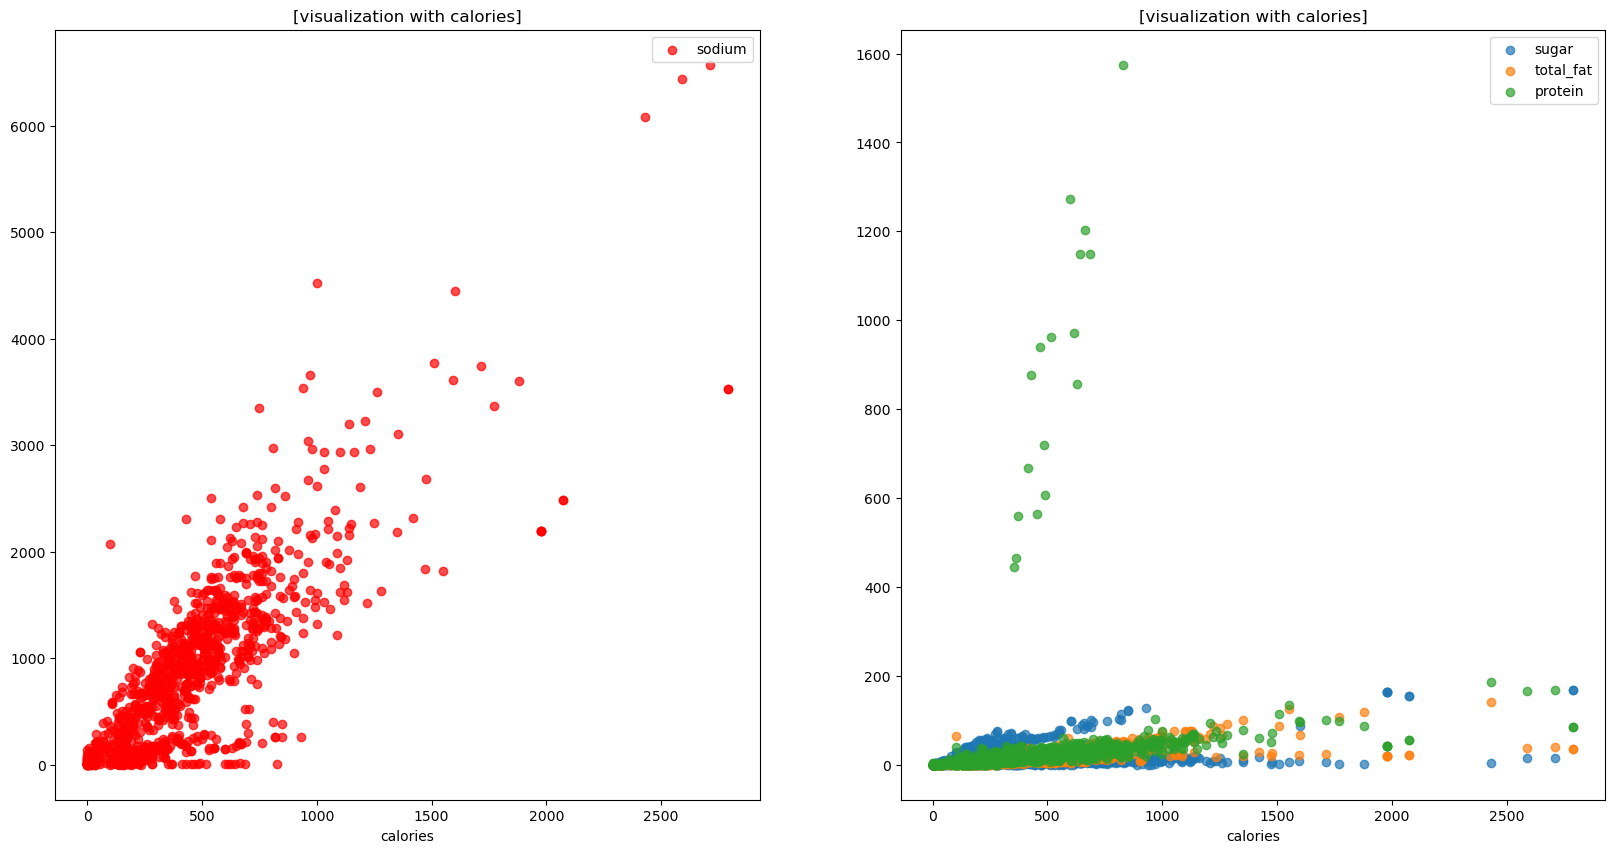

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.scatter(data['calories'], data['sodium'], label = 'sodium', c = 'red', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")

plt.subplot(1,2,2)
plt.scatter(data['calories'], data['sugar'], label = 'sugar', alpha = 0.7)
plt.scatter(data['calories'], data['total_fat'], label = 'total_fat', alpha = 0.7)
plt.scatter(data['calories'], data['protein'], label = 'protein', alpha = 0.7)
plt.legend(loc = 'best')
plt.xlabel('calories')
plt.title("[visualization with calories]")
plt.show()

## 데이터셋 분리

In [12]:
target = data['calories']
feature = data[['sodium','sugar','total_fat','protein']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, random_state = 425)

print(f"[훈련용] X_train : {X_train.shape}   y_train : {y_train.shape}")
print(f"[테스트용] X_test : {y_test.shape}   y_test : {y_test.shape}")

[훈련용] X_train : (801, 4)   y_train : (801,)
[테스트용] X_test : (267,)   y_test : (267,)


## 스케일링

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [15]:
X_train = pd.DataFrame(scaled_X_train, columns = ['sodium', 'sugar', 'total_fat', 'protein'])
X_test = pd.DataFrame(scaled_X_test, columns = ['sodium', 'sugar', 'total_fat', 'protein'])

In [16]:
# 스케일링이 잘 되었는지 확인해보자
"""
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TRAIN')

plt.subplot(1,2,2)
plt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)
plt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)
plt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)
plt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)
plt.legend(loc = 'best')
plt.title('preprocessing with STD scaler - TEST')

plt.tight_layout
plt.show()
"""

# 스케일링이 잘된 것을 확인했다

"\nplt.figure(figsize=(14,6))\nplt.subplot(1,2,1)\nplt.scatter(y_train, X_train['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_train, X_train['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_train, X_train['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_train, X_train['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TRAIN')\n\nplt.subplot(1,2,2)\nplt.scatter(y_test, X_test['sodium'], label = 'sodium', alpha = 0.5)\nplt.scatter(y_test, X_test['sugar'], label = 'sugar', alpha = 0.5)\nplt.scatter(y_test, X_test['total_fat'], label = 'total_fat', alpha = 0.5)\nplt.scatter(y_test, X_test['protein'], label = 'protein', alpha = 0.5)\nplt.legend(loc = 'best')\nplt.title('preprocessing with STD scaler - TEST')\n\nplt.tight_layout\nplt.show()\n"

## 학습 및 평가

In [17]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

In [21]:
model_01 = AdaBoostRegressor()
model_01.fit(X_train, y_train)
train_score = model_01.score(X_train, y_train)
test_score = model_01.score(X_test, y_test)
print(f"[train score] {train_score}      [test_score] {test_score}")

[train score] 0.7827652801778328      [test_score] 0.8302801791369199


In [22]:
model_02 = HistGradientBoostingRegressor()
model_02.fit(X_train, y_train)
train_score = model_02.score(X_train, y_train)
test_score = model_02.score(X_test, y_test)
print(f"[train score] {train_score}  [test_score] {test_score}")

[train score] 0.941164256388292  [test_score] 0.8957109263742226


In [23]:
model_03 = GradientBoostingRegressor()
model_03.fit(X_train, y_train)
train_score = model_03.score(X_train, y_train)
test_score = model_03.score(X_test, y_test)
print(f"[train score] {train_score}  [test_score] {test_score}")

[train score] 0.9510166614281074  [test_score] 0.9549542493779698


- GradientBoostingRegressor가 가장 점수 차이가 적기 때문에 이 모델로 채택했다.

In [25]:
y_pred = model_03.predict(X_test)
y_pred

array([5.30100510e+02, 2.63268514e+02, 1.96258731e+03, 1.96232874e+02,
       4.12044347e+02, 6.48807265e+02, 4.16668422e+02, 1.23588004e+02,
       5.01296191e+01, 7.70827715e+02, 7.48830306e+02, 5.38545587e+02,
       4.30482563e+02, 1.26264415e+02, 5.43925337e+02, 4.84828604e+02,
       6.64160451e+02, 5.45000318e+02, 7.84260660e+02, 1.46926550e+02,
       1.73210866e+00, 2.37398457e+02, 4.90273934e+02, 2.96914841e+02,
       6.19304465e+02, 3.79436663e+02, 4.05629646e+02, 4.77393292e+02,
       3.01740227e+02, 6.52576479e+01, 1.08701731e+02, 8.04682851e+02,
       8.07859260e+02, 8.31199250e+01, 6.58205254e+02, 4.93119138e+02,
       1.73210866e+00, 3.33224962e+02, 4.79189504e+02, 7.58974360e+00,
       3.19601170e+02, 2.41722566e+01, 4.26390411e+02, 3.62065923e+02,
       2.86893759e+02, 2.99373849e+02, 9.91776283e+02, 2.29893077e+02,
       2.94276803e+02, 2.96112629e+02, 1.61249919e+02, 4.47577674e+02,
       2.19806677e+01, 9.26290611e+02, 2.65358195e+02, 5.39498125e+02,
      

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

R2 SCORE : 0.9549542493779698
MSE : 7005.9611123350405
MAE : 61.159774451321844


----------------------

## 학습 및 평가 - decision_tree로 만든 모델을 활용해보기 (AdaBoostRegressor)

In [30]:
from joblib import load
model_file = './YSY_model/decision_tree_total_02.pkl'
model = load(model_file)

In [31]:
model

DecisionTreeRegressor(criterion='friedman_mse', max_depth=7, max_features=3,
                      min_impurity_decrease=3, min_samples_leaf=3,
                      min_samples_split=4)

In [38]:
boost_model = AdaBoostRegressor(model)
boost_model.fit(X_train, y_train)
train_score = boost_model.score(X_train, y_train)
test_score = boost_model.score(X_test, y_test)
print(f"[train score] {train_score}  [test score] {test_score}")

# ADA를 하니 확실히 올라갔다! 최적적합으로 튜닝시켜보면 점수를 더 끌어올릴 수 있지 않을까?

[train score] 0.9640746387152226  [test score] 0.9524433885964456


## 튜닝 : GridSearchCV

In [35]:
from sklearn.model_selection import GridSearchCV

boost_model = AdaBoostRegressor(model)

param = {
        'n_estimators':[50,100,150],
         'learning_rate':[0.1, 0.5, 1.0, 1.5],
         'loss':['linear', 'square','exponential']
         }
        
cv_num = 5

gs = GridSearchCV(boost_model, param_grid = param, cv = cv_num, return_train_score = True)

result = gs.fit(X_train, y_train)

resultDF = pd.DataFrame(gs.cv_results_)

print(f"max train score : {max(resultDF['mean_train_score'])}")
print(f"max test score : {max(resultDF['mean_test_score'])}\n")

# 최고 성능의 파라미터, 최고의 점수
print(f"best parameters : {gs.best_params_}")
print(f"best score : {gs.best_score_}")

# 튜닝을 하지 않는 것이 더 높은 점수가 나와서 튜닝을 하지 않는 것으로 최종 모델로 결정하겠다.

max train score : 0.9703733436990165
max test score : 0.8712063767688042

best parameters : {'learning_rate': 0.1, 'loss': 'linear', 'n_estimators': 50}
best score : 0.8712063767688042


In [39]:
total_model = boost_model

## 예측

In [40]:
y_pred = total_model.predict(X_test)
y_pred

array([ 609.36942675,  317.77777778, 1977.        ,  186.75      ,
        393.        ,  624.23076923,  411.44117647,  167.41666667,
        122.66666667,  652.        ,  685.        ,  490.02857143,
        442.60714286,  206.31578947,  552.14285714,  574.94444444,
        689.07377049,  576.11764706,  748.02061856,  172.5       ,
         49.90909091,  221.32258065,  427.51428571,  307.22222222,
        660.        ,  490.52631579,  392.85714286,  455.2       ,
        331.39534884,   77.8       ,  144.5       ,  803.33333333,
        740.66666667,  112.31578947,  711.50393701,  513.35820896,
         49.90909091,  302.38596491,  492.        ,   49.90909091,
        316.42857143,   66.75      ,  508.3488    ,  332.        ,
        306.74074074,  250.4       ,  996.33333333,  228.37037037,
        302.38596491,  295.23255814,  167.41666667,  443.7037037 ,
         66.75      ,  966.71428571,  262.        ,  590.        ,
        527.91891892,  383.33333333,  172.5       ,  742.09090

## 성능 평가

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [42]:
print(f"R2 SCORE : {r2_score(y_test, y_pred)}")
print(f"MSE : {mean_squared_error(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")

R2 SCORE : 0.9524433885964456
MSE : 7396.475039862805
MAE : 64.12161442660035


## 모델 저장

In [43]:
import joblib
import os

In [45]:
model_dir = './YSY_model/'
model_filename = model_dir + 'boosting_total.pkl'

# 저장 폴더 존재 여부 확인 후 저장
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
joblib.dump(model_03, model_filename)

['./YSY_model/boosting_total.pkl']